<a href="https://colab.research.google.com/github/PeopleOfPlay/transforCAOCH/blob/main/utils/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

     |████████████████████████████████| 4.2 MB 5.5 MB/s 
     |████████████████████████████████| 84 kB 2.0 MB/s 
     |████████████████████████████████| 596 kB 49.6 MB/s 
     |████████████████████████████████| 6.6 MB 37.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import os
import time
import datetime

import pandas as pd
import seaborn as sns
import numpy as np
import random

from google.colab import drive

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import get_linear_schedule_with_warmup

from tqdm.auto import tqdm

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train_path = '/content/drive/MyDrive/DataIA/fandecaoch/data/data_v2.csv'
batch_size = 1
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
seed_val = 42

In [5]:
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [6]:
device

device(type='cuda')

In [7]:
df = pd.read_csv(train_path, error_bad_lines=False, engine="python")  
df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


,id,comment,title,meta,director,cast
0,47326,La Passion du Christ : J’ai vraiment bien aimé...,La Passion du Christ,"Historique, Biopic, Drame",Mel Gibson,"Maia Morgenstern, Christo Jivkov"
1,30784,Predator 2 : Après le chef d’œuvre qui est le ...,Predator 2,"Science fiction, Action",Stephen Hopkins,"Danny Glover, Kevin Peter Hall, Gary Busey"
2,142987,Predators : Après un premier épisode qui est u...,Predators,"Action, Science fiction",Nimrod Antal,"Adrien Brody, Alice Braga, Topher Grace"
3,43225,Predator : Un classique du film d’action fanta...,Predator,"Fantastique, Action",John McTiernan,"Arnold Schwarzenegger, Carl Weathers, Elpidia ..."
4,61545,Prête-moi ta main : Une comédie romantique plu...,Prête-moi ta main,"Comédie, Romance",Eric Lartigau,"Alain Chabat, Charlotte Gainsbourg, Bernadette..."


In [8]:
df.dropna(inplace=True)
comments = df.comment.copy()
comments.head()

0    La Passion du Christ : J’ai vraiment bien aimé...
1    Predator 2 : Après le chef d’œuvre qui est le ...
2    Predators : Après un premier épisode qui est u...
3    Predator : Un classique du film d’action fanta...
4    Prête-moi ta main : Une comédie romantique plu...
Name: comment, dtype: object

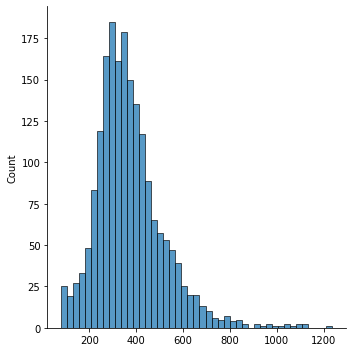

In [9]:
comment_lengths = []
for comment in comments:
    tokens = nltk.word_tokenize(comment)
    comment_lengths.append(len(tokens))
comment_lengths = np.array(comment_lengths)
sns.displot(comment_lengths)

In [10]:
np.average(comment_lengths)

371.71354436948627

In [11]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>')

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [12]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


In [13]:
class GPT2Dataset(Dataset):

    def __init__(self, df, tokenizer, max_length):

        self.tokenizer = tokenizer
        self.input_ids = []
        self.attn_masks = []

        for line in df.iterrows():
            input_ = f'{line[1].title} {line[1].meta} {line[1].director} {line[1].cast} :: {line[1].comment}'
            encodings_dict_input = tokenizer('<|startoftext|>'+ input_ + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")
            
            self.input_ids.append(torch.tensor(encodings_dict_input['input_ids']))
            self.attn_masks.append(torch.tensor(encodings_dict_input['attention_mask']))
            
    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx]

In [14]:
dataset = GPT2Dataset(df, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f'{train_size} training samples')
print(f'{val_size} validation samples')

1734 training samples
193 validation samples


In [15]:
train_dataloader = DataLoader(
    train_dataset,
    sampler = RandomSampler(train_dataset),
    batch_size = batch_size
)

validation_dataloader = DataLoader(
    val_dataset,
    sampler = SequentialSampler(val_dataset),
    batch_size = batch_size
)

In [16]:
epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8
sample_every = 100
total_steps = len(train_dataloader) * epochs

In [17]:
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)
model.resize_token_embeddings(len(tokenizer))

model.to(device)

optimizer = AdamW(
    model.parameters(),
    lr = learning_rate,
    eps = epsilon
)

scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps = warmup_steps, 
    num_training_steps = total_steps
)

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

In [18]:
total_t0 = time.time()
training_stats = []
model = model.to(device)

for epoch_i in range(0, epochs):
    print("")
    print(f'======== Epoch {epoch_i + 1} / {epochs} ========')
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    model.train()

    pbar = tqdm(train_dataloader)
    for batch in pbar:

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(
            b_input_ids,
            labels=b_labels, 
            attention_mask=b_masks,
            token_type_ids=None
        )

        loss = outputs[0]  
        batch_loss = loss.item()
        total_train_loss += batch_loss

        loss.backward()
        optimizer.step()
        scheduler.step()

        pbar.set_postfix({'loss': loss.item()})

    avg_train_loss = total_train_loss / len(train_dataloader)       
    training_time = format_time(time.time() - t0)

    print("")
    print(f"  Average training loss: {avg_train_loss}")
    print(f"  Training epoch took: {training_time}")

    print("")
    print("Running Validation...")

    model.eval()
    t0 = time.time()
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in tqdm(validation_dataloader):
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        
            outputs = model(
                b_input_ids, 
                attention_mask=b_masks,
                labels=b_labels
            )
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)    

    print(f"  Validation Loss: {avg_val_loss}")
    print(f"  Validation took: {validation_time}")

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print(f"Total training took {format_time(time.time()-total_t0)} (h:mm:ss)")


======== Epoch 1 / 5 ========
Training...


  0%|          | 0/1734 [00:00<?, ?it/s]


  Average training loss: 2.5312245036835215
  Training epoch took: 0:08:41

Running Validation...


  0%|          | 0/193 [00:00<?, ?it/s]

  Validation Loss: 1.9265785716049413
  Validation took: 0:00:17

======== Epoch 2 / 5 ========
Training...


  0%|          | 0/1734 [00:00<?, ?it/s]


  Average training loss: 1.7670954468616016
  Training epoch took: 0:08:53

Running Validation...


  0%|          | 0/193 [00:00<?, ?it/s]

  Validation Loss: 1.7661521078082565
  Validation took: 0:00:17

======== Epoch 3 / 5 ========
Training...


  0%|          | 0/1734 [00:00<?, ?it/s]


  Average training loss: 1.568844742015984
  Training epoch took: 0:08:52

Running Validation...


  0%|          | 0/193 [00:00<?, ?it/s]

  Validation Loss: 1.6956793911407648
  Validation took: 0:00:17

======== Epoch 4 / 5 ========
Training...


  0%|          | 0/1734 [00:00<?, ?it/s]


  Average training loss: 1.3997563245902838
  Training epoch took: 0:08:53

Running Validation...


  0%|          | 0/193 [00:00<?, ?it/s]

  Validation Loss: 1.6608453999838062
  Validation took: 0:00:17

======== Epoch 5 / 5 ========
Training...


  0%|          | 0/1734 [00:00<?, ?it/s]


  Average training loss: 1.2255014631781198
  Training epoch took: 0:08:52

Running Validation...


  0%|          | 0/193 [00:00<?, ?it/s]

  Validation Loss: 1.6780959350766296
  Validation took: 0:00:17

Training complete!
Total training took 0:45:36 (h:mm:ss)


In [19]:
output_dir = './model_save/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.json',
 './model_save/merges.txt',
 './model_save/added_tokens.json')

In [20]:
!ls -l --block-size=K ./model_save/

total 499792K
-rw-r--r-- 1 root root      1K May 20 17:25 added_tokens.json
-rw-r--r-- 1 root root      1K May 20 17:25 config.json
-rw-r--r-- 1 root root    446K May 20 17:25 merges.txt
-rw-r--r-- 1 root root 498441K May 20 17:25 pytorch_model.bin
-rw-r--r-- 1 root root      1K May 20 17:25 special_tokens_map.json
-rw-r--r-- 1 root root      1K May 20 17:25 tokenizer_config.json
-rw-r--r-- 1 root root    878K May 20 17:25 vocab.json


In [21]:
!ls -l --block-size=M ./model_save/pytorch_model.bin

-rw-r--r-- 1 root root 487M May 20 17:25 ./model_save/pytorch_model.bin


In [25]:
model.eval()
prompt = "<|startoftext|>Transformers 2  Action, Aventure, Science fiction, Thriller Michael Bay Shia LaBeouf, Megan Fox, Josh Duhamel ::"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
    generated, 
    do_sample=True,   
    top_k=50, 
    max_length = 500,
    top_p=0.95, 
    num_return_sequences=3
)

for i, sample_output in enumerate(sample_outputs):
  print(f"{i}: {tokenizer.decode(sample_output, skip_special_tokens=True)}\n\n")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257, 41762,   364,   362,   220,  7561,    11,   317,  5388,    11,
          5800, 10165,    11, 16283,  4665,  3899,  4696, 27424,  4689,  3856,
         37116,    11, 27616,  5426,    11,  8518, 10343,  2763,   417,  7904]],
       device='cuda:0')
0: Transformers 2  Action, Aventure, Science fiction, Thriller Michael Bay Shia LaBeouf, Megan Fox, Josh Duhamel :: Transformers 2  : Et bien, je viens en haleine le voir et moi je dis : chapeau a l’artiste car j’avais peur que il est vraiment énorme, c’est un grand réussit sur tous les points, je me suis franchement emporté par ce film qui est une réussit. Je m’attendais pas a aussi bon et captivant, la première surprise est déjà excellent et ça c’est de la bonne chose et c’est tant mieux que le premier. Moi sa me dérange pas et sa me dérange pas. Le film est une réussit car il fait de très bonne qualité, un certains réalisme et une belle réalisation pour mettre en scène les plus mémorables de l’action, les effets spéciaux qui

In [26]:
!zip -r model.zip model_save

  adding: model_save/ (stored 0%)
  adding: model_save/config.json (deflated 51%)
  adding: model_save/added_tokens.json (deflated 16%)
  adding: model_save/merges.txt (deflated 53%)
  adding: model_save/tokenizer_config.json (deflated 69%)
  adding: model_save/pytorch_model.bin (deflated 9%)
  adding: model_save/vocab.json (deflated 63%)
  adding: model_save/special_tokens_map.json (deflated 75%)
